In [91]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-11-2022)


In [92]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append('../../')
from Dataset_Creation import sys_dataset
import Dataset_load

## Read dataset

In [93]:
dataset_standard  = Dataset_load.create_asimov()
dataset_asimov  = Dataset_load.create_asimov()

## Single Cases

In [13]:
factors = np.array([0.])
sigma  =0.1
rnd = False


In [14]:
datasets = []
datasets_N = []

for i, factor in enumerate(factors):
    print(i, factor)
    sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = factor, 
                        tilt = 0,
                        bias = 0, 
                        resolution = 0,
                        e_reco_creation = 10,
                        rnd = False)
    dataset = sys_.create_dataset()
    dataset.models[0].parameters['lon_0'].frozen = True
    dataset.models[0].parameters['lat_0'].frozen = True
    datasets.append(dataset)

    dataset_N = sys_.create_dataset_N(10)
    
    
    zero = 1e-24
    
    ## addional parameter bias and resolution (ereco) but are frozen
    penalising_invcovmatrix = np.zeros((4, 4))
    np.fill_diagonal(penalising_invcovmatrix,
                     [1/zero**2, 1/zero**2, 1/sigma**2, 1/zero**2])


    dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
    
    dataset_N.models[0].parameters['lon_0'].frozen = True
    dataset_N.models[0].parameters['lat_0'].frozen = True
    datasets_N.append(dataset_N)
print(dataset)   

0 0.0
MapDataset
----------

  Name                            : VtuTYsWY 

  Total counts                    : 361333 
  Total background counts         : 360331.31
  Total excess counts             : 1001.76

  Predicted counts                : 361331.59
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1000.25

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753580.09

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameter

In [15]:
%%time
for i, factor in enumerate(factors):
    print(i, factor)
    fit = Fit(store_trace=False)
    result = fit.run([datasets[i]])


0 0.0
CPU times: user 2.14 s, sys: 20.7 ms, total: 2.16 s
Wall time: 2.16 s


In [16]:
%%time
for i, factor in enumerate(factors):
    fit_N = Fit(store_trace=False)
    result_N = fit_N.run([datasets_N[i]])
    print(i, factor, datasets_N[i].models.parameters['amplitude_nuisance'].value)


IndexError: No parameter: 'amplitude_nuisance'

# Stat Profiles

## Stat Profiles for BKG Norm

In [17]:
computing_norm = False
def make_writable(stat):
    write = dict()
    for k in stat.keys():
        if k != 'fit_results':
            write[k] = [float(i) for i in stat[k]]
            
                
    return write

In [18]:
%%time
if computing_norm :
    parameter = datasets[0].models.parameters['norm']
    sigma = 2
    parameter.scan_n_sigma  = sigma
    stat_profile = fit.stat_profile([datasets[0]], parameter, reoptimize= True)
    stat_profile['scale_scan'] = stat_profile.pop(next(iter(stat_profile)) )    
    with open('data/5_scan_norm.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile), file)
else:
    with open('data/5_scan_norm.yaml') as file:
        stat_profile = yaml.load( file, Loader=yaml.FullLoader)

    

CPU times: user 2.26 ms, sys: 0 ns, total: 2.26 ms
Wall time: 2.2 ms


In [19]:
%%time
if computing_norm :
    parameter = datasets_N[0].models.parameters['norm']
    sigma = 2
    parameter.scan_n_sigma  = sigma
    stat_profile_N = fit.stat_profile([datasets_N[0]], parameter, reoptimize = True)
    stat_profile_N['scale_scan'] = stat_profile_N.pop(next(iter(stat_profile_N)) )    
    with open('data/5_scan_norm_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N), file)
    for k in stat_profile_N:
        if "spectral" in k:
            key_name = "scale_scan"
            stat_profile_N[key_name] = stat_profile_N[k]      
else:
    with open('data/5_scan_norm_N.yaml') as file:
        stat_profile_N = yaml.load( file, Loader=yaml.FullLoader)

    

CPU times: user 812 µs, sys: 509 µs, total: 1.32 ms
Wall time: 1.24 ms


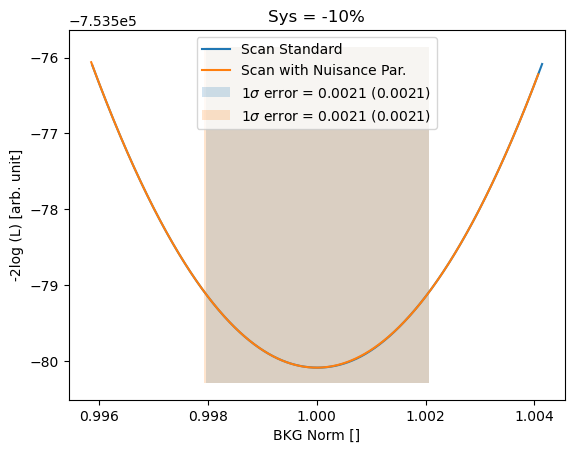

In [22]:
sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis"
)
sys.path.append('../')
import upper_limit_18_02

fig = plt.figure()
ll_N = stat_profile_N.copy()
ul_N = upper_limit_18_02.upper_limit(ll_N,0,0)
L_N, x_N = ul_N.interpolate()
plt.plot(x_N, L_N(x_N),label ="Scan Standard")

ll = stat_profile.copy()
ul = upper_limit_18_02.upper_limit(ll,0,0)
L, x = ul.interpolate()
plt.plot(x, L(x),label ="Scan with Nuisance Par.")

norm_err_N = datasets_N[0].models.parameters['norm'].error
norm_err = datasets[0].models.parameters['norm'].error


min_, er, upp = ul_N.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err_N:.2})')
min_, er, upp = ul.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err:.2})')

plt.xlabel("BKG Norm []")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-4)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_norm.png")

## Stat Profiles for Source Signal

In [23]:
%%time
computing_amplitude = True

if computing_amplitude:
    sigma = 2
    parameter_a = datasets[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_a = fit.stat_profile([datasets[0]], parameter_a, reoptimize= True)
    stat_profile_a['scale_scan'] = stat_profile_a.pop(next(iter(stat_profile_a)) )    
    with open('data/5_scan_amplitude.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_a), file)
    
else:
    with open('data/5_scan_amplitude.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 22.3 s, sys: 71 ms, total: 22.4 s
Wall time: 22.4 s


In [26]:
%%time
computing_amplitude_N = True
if computing_amplitude_N:
    sigma = 2
    parameter_a = datasets_N[0].models.parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_N_a = fit.stat_profile([datasets_N[0]], parameter_a, reoptimize = True)
    stat_profile_N_a['scale_scan'] = stat_profile_N_a.pop(next(iter(stat_profile_N_a)) )    
    
    with open('data/5_scan_amplitude_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_a), file)
    
else:
    with open('data/5_scan_amplitude_N.yaml') as file:
        stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 20min 51s, sys: 36min 42s, total: 57min 33s
Wall time: 9min 27s


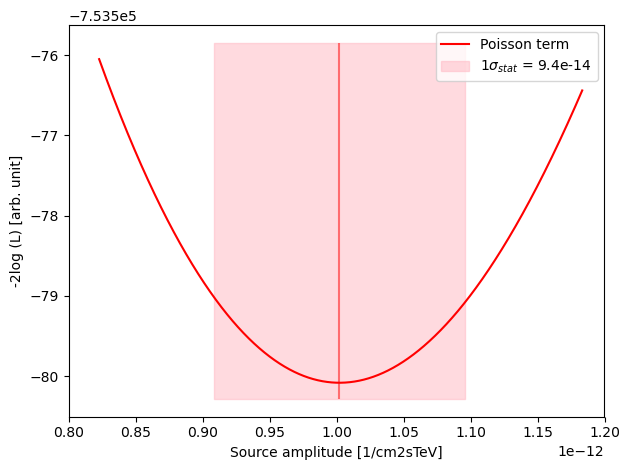

In [89]:
fig = plt.figure()

ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "Poisson term", color = 'red')

amplitude_err = datasets[0].models[0].parameters['amplitude'].error

min_, er, upp = ul_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ylim = plt.ylim()
plt.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.5, 
                label = '1$\sigma_{stat}$' +f' = {er:.2}' , color = 'lightpink')
plt.vlines(min_, ylim[0], ylim[1], color = 'red', alpha = 0.5)

plt.xlabel("Source amplitude [1/cm2sTeV]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
plt.xlim(0.8e-12, 1.2e-12)

plt.tight_layout()
fig.savefig("plots/5_stat_scan_amplitude_st.png")

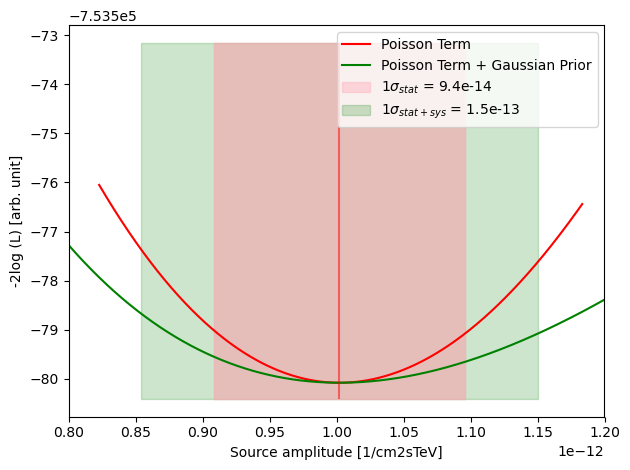

In [90]:
fig = plt.figure()

ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "Poisson Term", color = 'red')

ll_N_a = stat_profile_N_a.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Poisson Term + Gaussian Prior", color = 'green')


amplitude_err = datasets[0].models[0].parameters['amplitude'].error
amplitude_err_N = datasets_N[0].models[0].parameters['amplitude'].error

min_, er, upp = ul_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.5, 
                label = '1$\sigma_{stat}$' +f' = {er:.2}' , color = 'lightpink')
ax.vlines(min_, ylim[0], ylim[1], color = 'red', alpha = 0.5)


min_N, erN, upp = ul_N_a.likelihood_upper()
min_N = min_N[0]; erN = erN[0]
ax.fill_between(  [min_N-erN, min_N+ erN], ylim[0], ylim[1], alpha = 0.2, 
                label = '1$\sigma_{stat+sys}$' +f' = {erN:.2} ',
               color = 'green')

ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.5, 
                label = '' , color = 'lightpink')

plt.xlabel("Source amplitude [1/cm2sTeV]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
plt.xlim(0.8e-12, 1.2e-12)

plt.tight_layout()
fig.savefig("plots/5_stat_scan_amplitude.png")

## Stat Profiles for Source Index

In [15]:
%%time
computing_index = 0

if computing_index:
    sigma = 2
    parameter_i = datasets[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_i = fit.stat_profile([datasets[0]], parameter_i, reoptimize= True)
    stat_profile_i['scale_scan'] = stat_profile_i.pop(next(iter(stat_profile_i)) )    
    with open('data/5_scan_index.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_i), file)
    
else:
    with open('data/5_scan_index.yaml') as file:
        stat_profile_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 2.07 ms, sys: 25 µs, total: 2.1 ms
Wall time: 2.84 ms


In [16]:
%%time
computing_index_N = 0
if computing_index_N:
    sigma = 2
    parameter_i = datasets_N[0].models.parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_N_i = fit.stat_profile([datasets_N[0]], parameter_i, reoptimize = True)
    stat_profile_N_i['scale_scan'] = stat_profile_N_i.pop(next(iter(stat_profile_N_i)) )    
    
    with open('data/5_scan_index_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_i), file)
    
else:
    with open('data/5_scan_index_N.yaml') as file:
        stat_profile_N_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

CPU times: user 1.9 ms, sys: 0 ns, total: 1.9 ms
Wall time: 2.83 ms


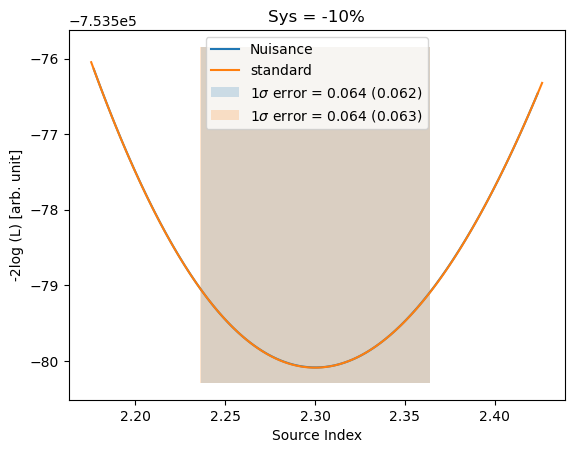

In [17]:
fig = plt.figure()
ll_N_a = stat_profile_N_i.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance")


ll_a = stat_profile_i.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "standard")

index_err = datasets[0].models[0].parameters['index'].error
index_err_N = datasets_N[0].models[0].parameters['index'].error



min_, er, upp = ul_N_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({index_err_N:.2})')
min_, er, upp = ul_a.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({index_err:.2})')

plt.xlabel("Source Index")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend()
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = -10%")

fig.savefig("plots/5_stat_scan_index.png")

## Penalty Examples

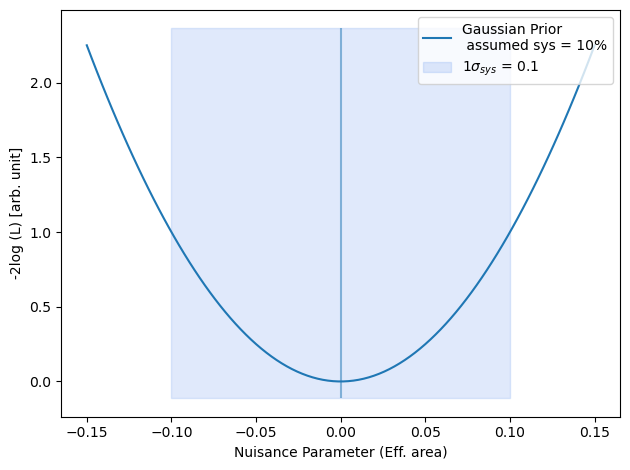

In [86]:
fig = plt.figure()
ps = [ 0.1]
plot_values = np.linspace(-0.15, 0.15, 100)
for p in ps:
    plt.plot(plot_values, plot_values ** 2 / p ** 2, label =  "Gaussian Prior \n assumed sys = 10%") 
ylim = plt.ylim()
plt.fill_between(  [-0.1, 0.1], ylim[0], ylim[1], alpha = 0.2, 
                label = '1$\sigma_{sys}$' +f' = {ps[0]} ',
               color = 'cornflowerblue')
plt.vlines(0, ylim[0], ylim[1], color = 'tab:blue', alpha = 0.5)

plt.ylabel("-2log (L) [arb. unit]") 
plt.legend(loc = 'upper right')

plt.xlabel('Nuisance Parameter (Eff. area)')
plt.tight_layout()
fig.savefig('plots/5_gaussian_penalty_example.pdf')